In [20]:
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import matplotlib.colors as mcolors
#%matplotlib inline

from sim.simulation import Simulation
from sim.predator import Predator
from sim.prey import Prey

In [32]:
# Configuración de la simulación
sim = Simulation(size=30, 
                 initial_prey=50, 
                 initial_predators=15,
                 max_steps=100,
                 grass_regrowth_rate=0.15,
                 rock_density=0.15)

# Almacenar estadísticas durante la simulación
prey_population = []
predator_population = []
energy_levels = []
grass_levels = []
ecosystem_states = {}

# Ejecutar la simulación y recolectar datos
for step in range(sim.max_steps):
    if not sim.next_step():
        break
    
    # Registrar estadísticas
    prey, pred = sim.get_population_counts()
    prey_population.append(prey)
    predator_population.append(pred)
    
    # Calcular energía promedio
    prey_energy = [a.energy for a in sim.animals if isinstance(a, Prey) and a.alive]
    pred_energy = [a.energy for a in sim.animals if isinstance(a, Predator) and a.alive]
    energy_levels.append({
        'prey_avg': np.mean(prey_energy) if prey_energy else 0,
        'pred_avg': np.mean(pred_energy) if pred_energy else 0
    })
    
    # Calcular nivel de hierba
    total_grass = 0
    fertile_cells = 0
    for row in sim.ecosystem.map:
        for cell in row:
            if cell.terrain_type == "soil":
                total_grass += cell.grass_amount
                fertile_cells += 1
    avg_grass = total_grass / fertile_cells if fertile_cells else 0
    grass_levels.append(avg_grass)
    
    # Guardar estado del ecosistema cada 10 pasos

    ecosystem_states[step] = deepcopy(sim.ecosystem.map)

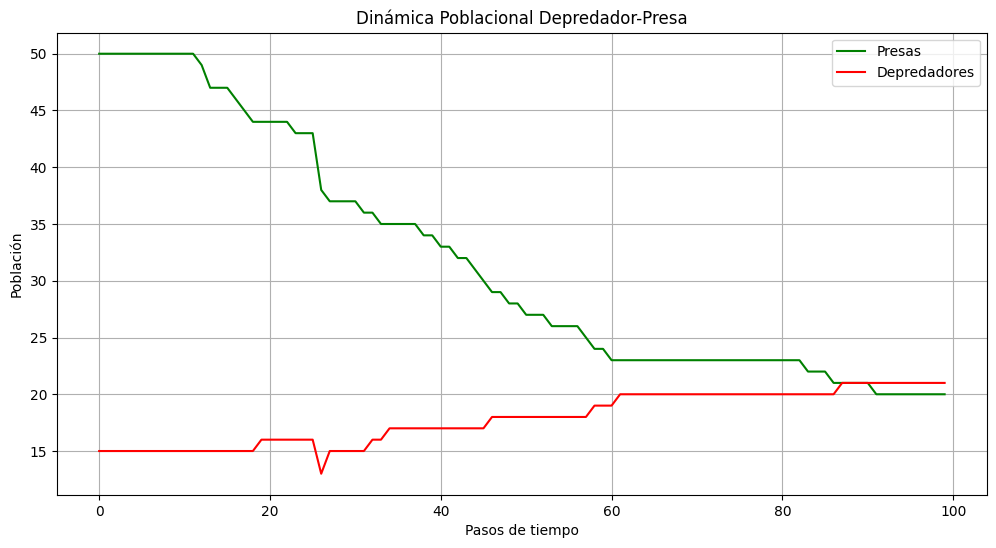

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(prey_population, label='Presas', color='green')
plt.plot(predator_population, label='Depredadores', color='red')
plt.title('Dinámica Poblacional Depredador-Presa')
plt.xlabel('Pasos de tiempo')
plt.ylabel('Población')
plt.legend()
plt.grid(True)
plt.show()

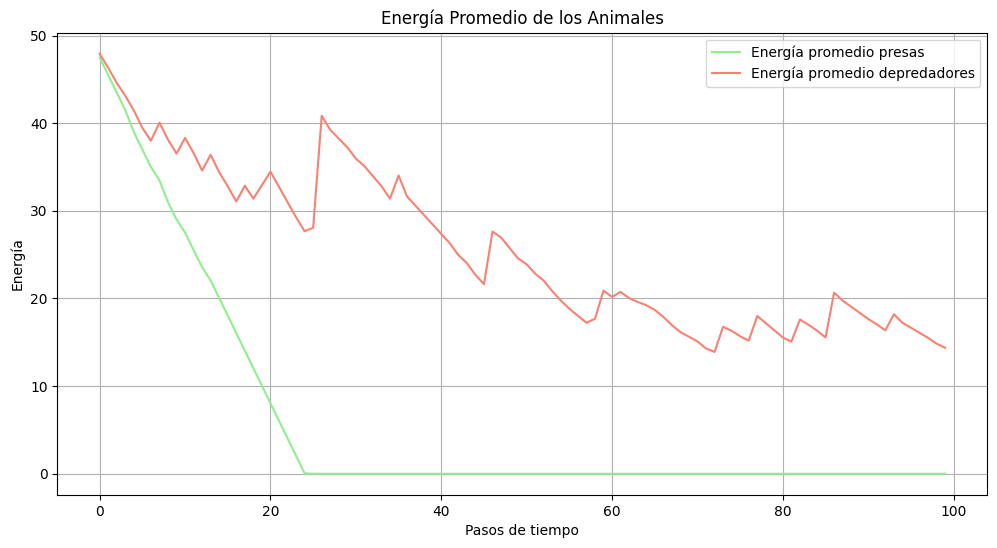

In [24]:
prey_energy = [e['prey_avg'] for e in energy_levels]
pred_energy = [e['pred_avg'] for e in energy_levels]

plt.figure(figsize=(12, 6))
plt.plot(prey_energy, label='Energía promedio presas', color='lightgreen')
plt.plot(pred_energy, label='Energía promedio depredadores', color='salmon')
plt.title('Energía Promedio de los Animales')
plt.xlabel('Pasos de tiempo')
plt.ylabel('Energía')
plt.legend()
plt.grid(True)
plt.show()

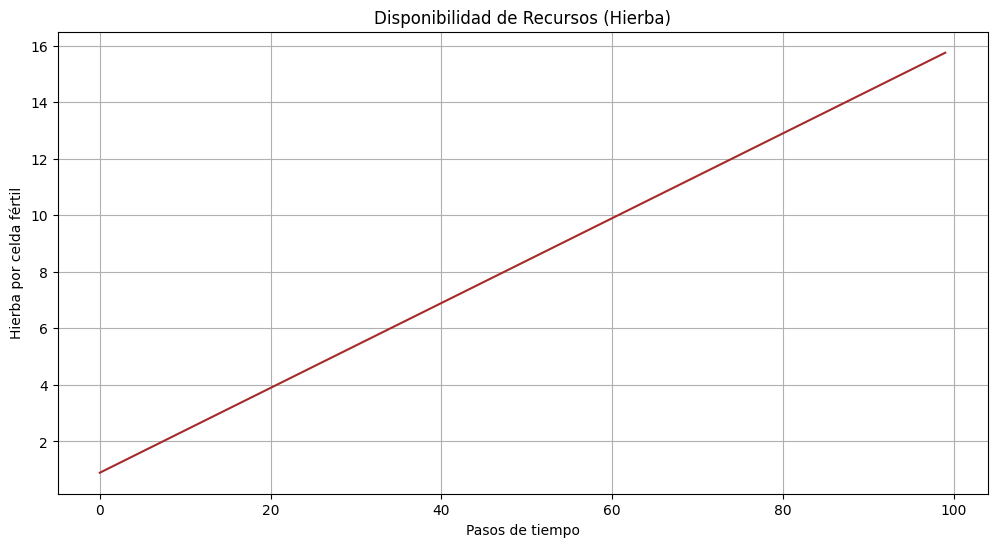

In [25]:
# 3. Gráfico de hierba promedio
plt.figure(figsize=(12, 6))
plt.plot(grass_levels, label='Hierba promedio', color='brown')
plt.title('Disponibilidad de Recursos (Hierba)')
plt.xlabel('Pasos de tiempo')
plt.ylabel('Hierba por celda fértil')
plt.grid(True)
plt.show()

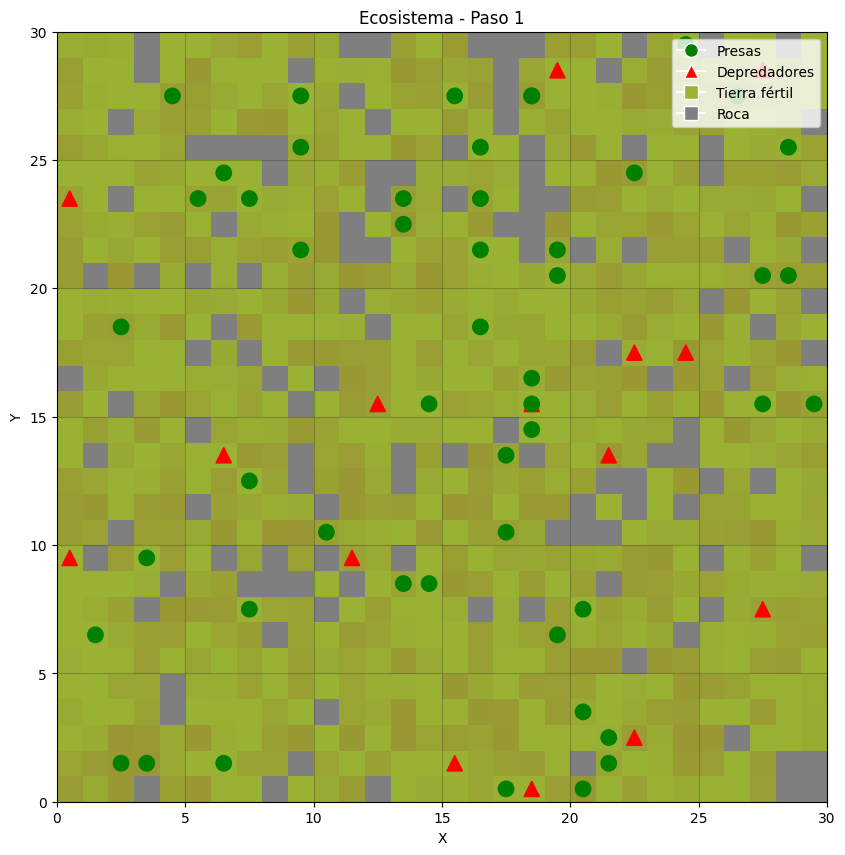

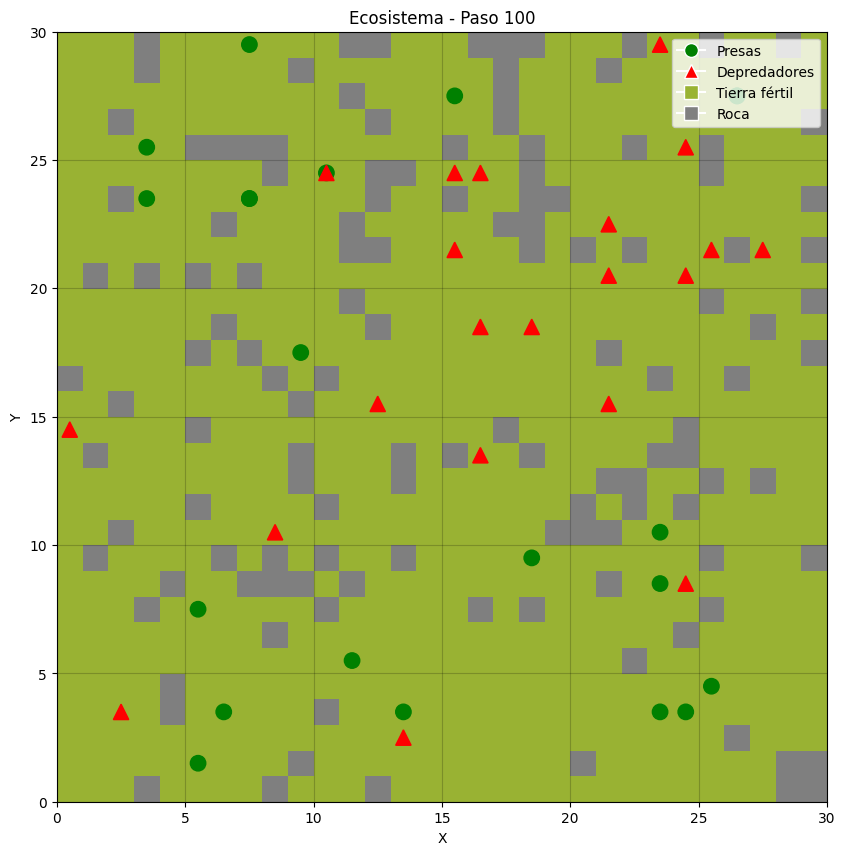

In [34]:
# 4. Visualización del mapa del ecosistema
def plot_ecosystem(map, step, ax=None):
    """Visualiza el estado actual del ecosistema"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        ax.clear()
    
    # Crear matriz para visualización
    grid = np.zeros((len(map), len(map), 3))
    
    for r in range(len(map)):
        for c in range(len(map)):
            cell = map[r][c]
            
            # Colorear según el tipo de terreno
            if cell.terrain_type == "rock":
                # Gris para rocas
                grid[r, c] = [0.5, 0.5, 0.5]
            else:
                # Marrón para tierra con tono según la hierba
                grass_intensity = min(1.0, cell.grass_amount)
                grid[r, c] = [0.6, 0.4 + grass_intensity*0.3, 0.2]
                
            # Agregar animales
            for animal in cell.occupants:
                if isinstance(animal, Prey) and animal.alive:
                    # Círculo verde para presas
                    ax.add_patch(plt.Circle((c + 0.5, r + 0.5), 0.3, color='green'))
                elif isinstance(animal, Predator) and animal.alive:
                    # Triángulo rojo para depredadores
                    ax.add_patch(plt.Polygon([[c+0.5, r+0.8], [c+0.2, r+0.2], [c+0.8, r+0.2]], color='red'))
    
    ax.imshow(grid, origin='lower', extent=[0, len(map), 0, len(map)])
    ax.set_title(f'Ecosistema - Paso {step}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.grid(True, color='black', alpha=0.2)
    
    # Leyenda
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Presas'),
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Depredadores'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=[0.6, 0.7, 0.2], markersize=10, label='Tierra fértil'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=[0.5, 0.5, 0.5], markersize=10, label='Roca')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    return ax

# Visualizar mapa inicial
fig, ax = plt.subplots(figsize=(10, 10))
plot_ecosystem(ecosystem_states[0], 1, ax)
plt.show()

# Visualizar mapa final
fig, ax = plt.subplots(figsize=(10, 10))
plot_ecosystem(ecosystem_states[90], 100, ax)
plt.show()

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

def update(frame):
    ecosystem = ecosystem_states[frame]
    plot_ecosystem(ecosystem, frame, ax)
    return ax,

ani = FuncAnimation(fig, update, frames=len(ecosystem_states), interval=500, blit=False)
plt.close(fig)  # Evitar mostrar el frame estático

# Mostrar la animación en el notebook
HTML(ani.to_jshtml())